### Packages

In [1]:
# Data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

# Added
import statsmodels.formula.api as smf

### Functions

In [2]:
# Define function that print the minimum and maximum values of a defines variable in the data frame
def get_min_and_max(df, variable_name, no_min, no_max):
    array = df[variable_name].fillna(0).unique()
    sorted_array = np.sort(array)
    
    min_values = sorted_array[:no_min]
    max_values = sorted_array[-no_max:]
    
    print(f"{no_min} minimum values of '{variable_name}':")
    print(min_values)
    print('\n')
    print(f"{no_max} maximum values of '{variable_name}':")
    print(max_values)

In [3]:
def plot_distribution(data, column_name):
    # Create a figure with two vertically aligned subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

    # Plotting the histogram
    sns.histplot(data[column_name], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {column_name}")
    axes[0].set_xlabel(f"{column_name}")
    axes[0].set_ylabel("Frequency")

    # Plotting the boxplot
    sns.boxplot(x=data[column_name], ax=axes[1])
    axes[1].set_title(f"Distribution of {column_name}")
    axes[1].set_xlabel(f"{column_name}")

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Data wrangling and exploration

We begin by loading the two data sets and looking at the different attributes. We decide to add two columns **Movie release year** and **Actor birth year**.

In [4]:
# Load datasets
data_folder = './data_cleaned/'
movie_metadata = pd.read_csv(data_folder + 'movie_cleaned.csv', lineterminator='\n')
character_metadata = pd.read_csv(data_folder + 'character_cleaned.csv')

/var/folders/zp/zj6kbf7d5mv37j0rsdb53g200000gn/T/ipykernel_13646/132682489.py:3: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv(data_folder + 'movie_cleaned.csv', lineterminator='\n')


# Start Emma

**Change column names**

In [5]:
# Replace spaces with underscores in column names
movie_metadata.columns = movie_metadata.columns.str.replace(' ', '_')
character_metadata.columns = character_metadata.columns.str.replace(' ', '_')

**Filter so that only movies with revenue are included**


In [6]:
movie_metadata = movie_metadata[movie_metadata['Movie_box_office_revenue'].notna()]

In [7]:
movie_metadata.shape

(10018, 26)

**Look at attributes and see where we have missing data**

In [8]:
movie_metadata.isna().sum()

Unnamed:_0                         0
Wikipedia_Movie_ID                 0
Freebase_Movie_ID                  0
Movie_name                         0
Movie_release_date                73
Movie_runtime                    308
Movie_languages                    0
Movie_countries                    0
Movie_genres                       0
TMDB_id                          123
TMDB_original_language           123
TMDB_original_title              123
TMDB_overview                    143
TMDB_popularity                  123
TMDB_release_date                152
TMDB_title                       123
TMDB_vote_average                123
TMDB_vote_count                  123
TMDB_runtime                    4688
TMDB_budget                     4688
TMDB_IMDB_id                    4727
TMDB_genres                     4718
Movie_box_office_revenue           0
Movie_release_year                74
log_Movie_box_office_revenue       0
log_Movie_release_year            74
dtype: int64

We are missing vote average data from 123 movies. Since we want to build a linear regression model on this column we further filter the data to only include movies where there is an vote averag. You can also see that a lot of budget data is missing. As we will see later we do not think we can use this data and we will therefore not filter for this value. 

In [9]:
movie_metadata = movie_metadata[movie_metadata['TMDB_vote_average'].notna()]

In [10]:
movie_metadata.shape

(9895, 26)

**TMDB vote count**

We will now look at the TMDB vote count column

In [11]:
get_min_and_max(df=movie_metadata, variable_name='TMDB_vote_count', no_min=10, no_max=10)

10 minimum values of 'TMDB_vote_count':
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


10 maximum values of 'TMDB_vote_count':
[24843. 24994. 25554. 25601. 26088. 27446. 29290. 29943. 30843. 34697.]


In [12]:
movie_metadata['TMDB_vote_count'].describe()

count     9895.000000
mean      1015.483679
std       2401.807889
min          0.000000
25%         40.000000
50%        192.000000
75%        865.500000
max      34697.000000
Name: TMDB_vote_count, dtype: float64

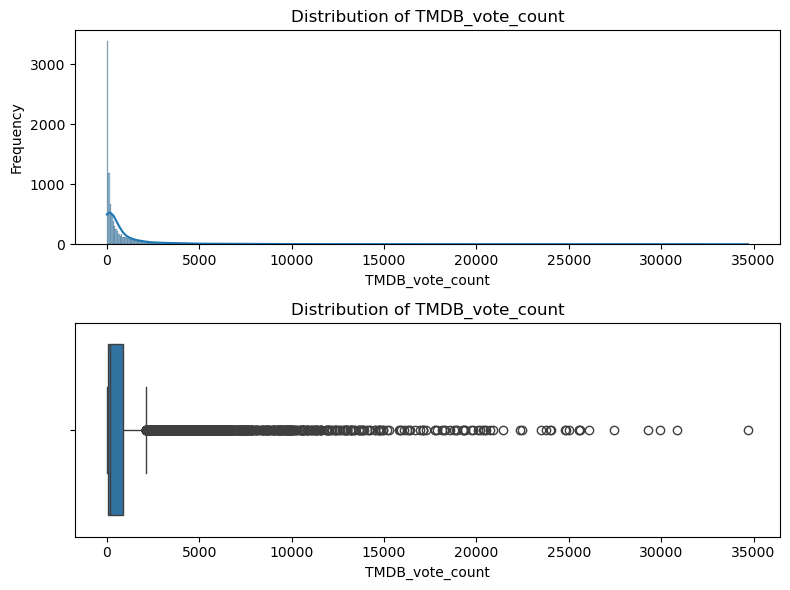

In [13]:
# Example usage
plot_distribution(movie_metadata, 'TMDB_vote_count')


We see that a lot of movies have 0 vote counts and the data is heavily tailed. It does not make sense to include data for movies where the vote count is 0. We can first try get an overview over how much data we would loose if we filter out only the movies with 0 votes. Then we look at other cut-off values to get an overview. 

In [14]:
# Create a copy of the original DataFrame for comparison
original_df = movie_metadata.copy()

# Define a list of cutoff values to test
cutoff_values = [0, 1, 2, 4, 6, 8, 10, 20, 50]  # Add more values as needed

# Create a dictionary to store results
data_loss_results = {'Cutoff Value': [], 'Data Loss Percentage': [], 'Data Length': []}

# Iterate through cutoff values
for cutoff in cutoff_values:
    # Create a condition based on the cutoff
    condition = (original_df['TMDB_vote_count'] >= cutoff)
    
    # Apply the condition to filter the DataFrame
    filtered_df = original_df[condition]
    
    # Calculate the percentage of data loss
    data_loss_percentage = ((len(original_df) - len(filtered_df)) / len(original_df)) * 100
    data_length = len(filtered_df)

    # Append the results to the dictionary
    data_loss_results['Cutoff Value'].append(cutoff)
    data_loss_results['Data Loss Percentage'].append(data_loss_percentage)
    data_loss_results['Data Length'].append(data_length)

# Convert the results dictionary to a DataFrame for easier visualization
results_df = pd.DataFrame(data_loss_results)

# Print or visualize the results
results_df


,Cutoff Value,Data Loss Percentage,Data Length
0,0,0.000000,9895
1,1,1.616978,9735
2,2,2.486104,9649
3,4,4.325417,9467
4,6,6.083881,9293
5,8,7.983830,9105
6,10,9.530066,8952
7,20,15.957554,8316
8,50,27.892875,7135


We decide to remove movies with less than 4 votes.

In [15]:
condition = (movie_metadata['TMDB_vote_count'] >= 4)
movie_metadata = movie_metadata[condition]

We create a new column with a log transformation of the column. 

In [16]:
movie_metadata['log_TMDB_vote_count']= np.log(movie_metadata['TMDB_vote_count'])

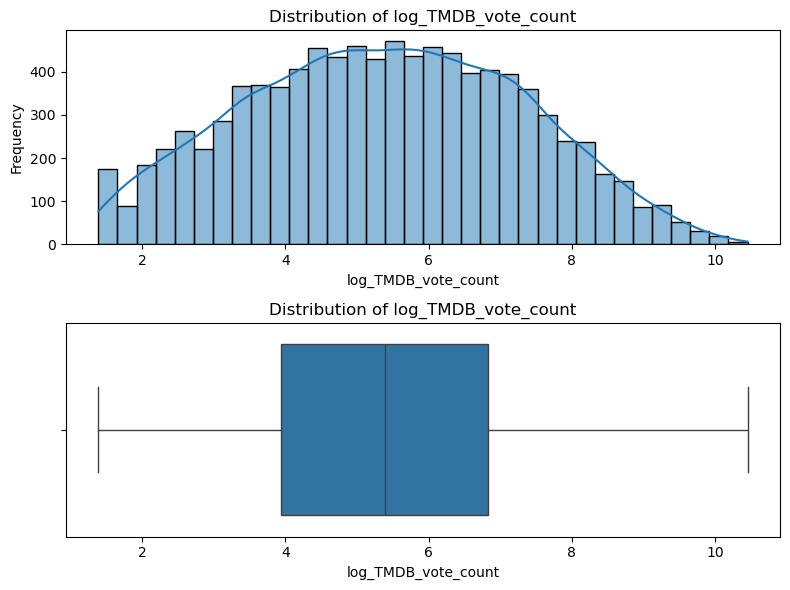

In [17]:
# Example usage
plot_distribution(movie_metadata, 'log_TMDB_vote_count')

**Runtime**

We now look at the runtime of the movie. We both have runtime from the original dataset and from the TMDB dataset. We can see that a lot of data is missing in TMDB runtime. Also data is missing in the movie metadata 

In [18]:
movie_metadata['TMDB_runtime'].isna().sum()

4363

In [19]:
movie_metadata['Movie_runtime'].isna().sum()

247

We want to populate the Movie runtime column with data from the the TMDB runtime column

In [20]:
# Fill missing values in 'Movie_runtime' with values from 'TMDB_runtime'
movie_metadata['Movie_runtime'] = movie_metadata['Movie_runtime'].fillna(movie_metadata['TMDB_runtime'])
movie_metadata['Movie_runtime'].isna().sum()

44

We now want to look at whether the `Movie runtime`` data should be filtered

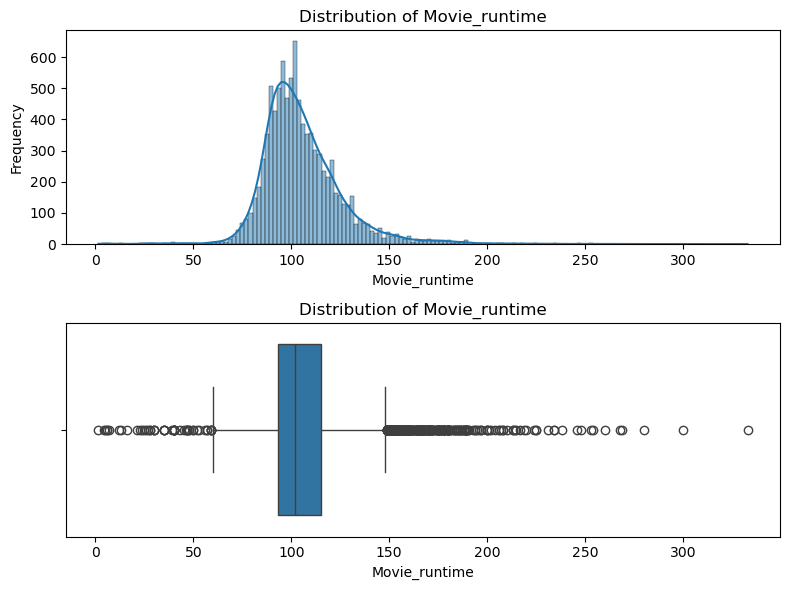

In [21]:
# Example usage
plot_distribution(movie_metadata, 'Movie_runtime')

We decide to only filter movies with runtime of 0

In [22]:
get_min_and_max(df=movie_metadata, variable_name='Movie_runtime', no_min=5, no_max=5)

5 minimum values of 'Movie_runtime':
[0.  1.5 4.5 5.  6. ]


5 maximum values of 'Movie_runtime':
[268. 269. 280. 300. 333.]


In [23]:
condition = (movie_metadata['Movie_runtime'] > 0)
movie_metadata = movie_metadata[condition]

In [24]:
movie_metadata.shape

(9423, 27)

**Revenue/budget**

/Users/emmaceleste/miniconda3/envs/ada/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


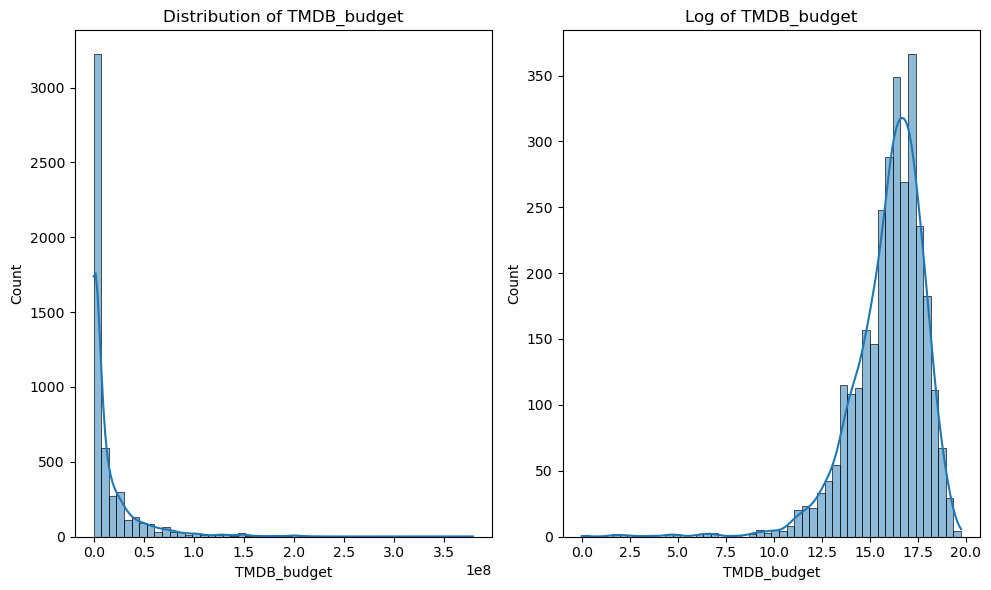

In [25]:
plt.figure(figsize=(10, 6))

# Plot the first histogram
plt.subplot(1, 2, 1)
sns.histplot(movie_metadata['TMDB_budget'], kde=True, bins=50)
plt.title("Distribution of TMDB_budget")

# Plot the second histogram
plt.subplot(1, 2, 2)
sns.histplot(np.log(movie_metadata['TMDB_budget']), kde=True, bins=50)
plt.title("Log of TMDB_budget")

plt.tight_layout()
plt.show()

In [26]:
get_min_and_max(df=movie_metadata, variable_name='TMDB_budget', no_min=10, no_max=10)

10 minimum values of 'TMDB_budget':
[  0.   1.   5.   6.   8.  12.  35.  90. 107. 120.]


10 maximum values of 'TMDB_budget':
[2.09e+08 2.10e+08 2.15e+08 2.20e+08 2.25e+08 2.37e+08 2.50e+08 2.58e+08
 3.56e+08 3.79e+08]


Count how many movies have a budget of 0. Since so many movies have a budget of 0 we should probably exclude this data

In [27]:
print('Data loss in TMDB budget:',(movie_metadata[movie_metadata['TMDB_budget'] == 0]['TMDB_budget'].count()+movie_metadata['TMDB_budget'].isna().sum()))
print('Percentage data loss:', round((movie_metadata[movie_metadata['TMDB_budget'] == 0]['TMDB_budget'].count()+movie_metadata['TMDB_budget'].isna().sum())/movie_metadata['TMDB_budget'].shape[0]*100,1),'%')

Data loss in TMDB budget: 6395
Percentage data loss: 67.9 %


If we were to include the TMDB budget column we would loose 68% of our data. We deem this to be too much dataloss for now. In a further dataexploration we might deem it a significant factor and include it.

We do however include a column of log-transformed budgets for budgets over 0 $.

In [28]:
movie_metadata['TMDB_budget'] = movie_metadata['TMDB_budget'].replace(0, np.nan)
movie_metadata['log_TMDB_budget'] = np.log(movie_metadata['TMDB_budget'])

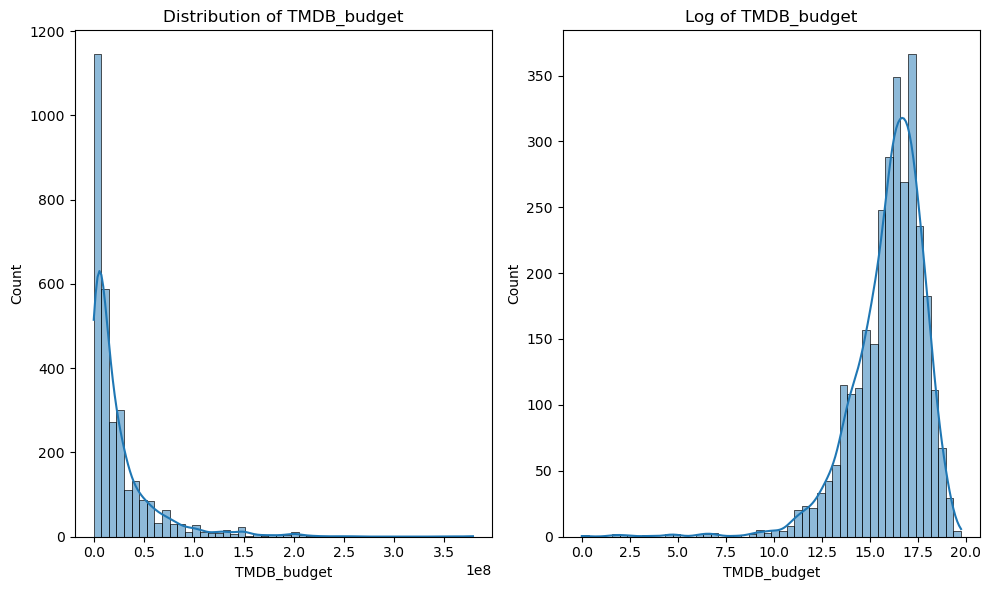

In [29]:
plt.figure(figsize=(10, 6))

# Plot the first histogram
plt.subplot(1, 2, 1)
sns.histplot(movie_metadata['TMDB_budget'], kde=True, bins=50)
plt.title("Distribution of TMDB_budget")

# Plot the second histogram
plt.subplot(1, 2, 2)
sns.histplot(np.log(movie_metadata['TMDB_budget']), kde=True, bins=50)
plt.title("Log of TMDB_budget")

plt.tight_layout()
plt.show()

**Male actor percentage**

We filter the character metadata so that only movies in movie metadata are included

In [30]:
# Get a list of unique movie IDs from movie_metadata
unique_movie_ids = movie_metadata['Wikipedia_Movie_ID'].unique()

# Filter character_metadata based on the unique movie IDs
character_metadata = character_metadata[character_metadata['Wikipedia_Movie_ID'].isin(unique_movie_ids)]


In [31]:
#Group character_metadata by 'Wikipedia Movie ID' and calculate the percentage of male/female actors in each movie
male_percentage_per_movie = character_metadata.groupby('Wikipedia_Movie_ID')['Actor_gender'].apply(lambda x: (x == 'M').sum() / len(x) * 100).reset_index()
male_percentage_per_movie.columns = ['Wikipedia_Movie_ID', 'Male_actor_percentage']


# Merge the m dataframe with movie_metadata on 'Wikipedia Movie ID'
movie_metadata = pd.merge(movie_metadata, male_percentage_per_movie, on='Wikipedia_Movie_ID', how='left')


**Average age of actors**

In [32]:
# Group character_metadata by 'Wikipedia Movie ID' and calculate the average birth year of actors in each movie
average_actor_age_per_movie = character_metadata.groupby('Wikipedia_Movie_ID')['Actor_age_at_movie_release'].mean().reset_index()
average_actor_age_per_movie.columns = ['Wikipedia_Movie_ID', 'Mean_actor_age_at_movie_release']

# Merge the dataframe with movie_metadata on 'Wikipedia Movie ID'
movie_metadata = pd.merge(movie_metadata, average_actor_age_per_movie, on='Wikipedia_Movie_ID', how='left')


In [33]:
np.isinf(movie_metadata.select_dtypes(include=['number']).sum())

Unnamed:_0                         False
Wikipedia_Movie_ID                 False
Movie_runtime                      False
TMDB_id                            False
TMDB_popularity                    False
TMDB_vote_average                  False
TMDB_vote_count                    False
TMDB_runtime                       False
TMDB_budget                        False
Movie_box_office_revenue           False
Movie_release_year                 False
log_Movie_box_office_revenue       False
log_Movie_release_year             False
log_TMDB_vote_count                False
log_TMDB_budget                    False
Male_actor_percentage              False
Mean_actor_age_at_movie_release    False
dtype: bool

**Plot histrogram of every column**

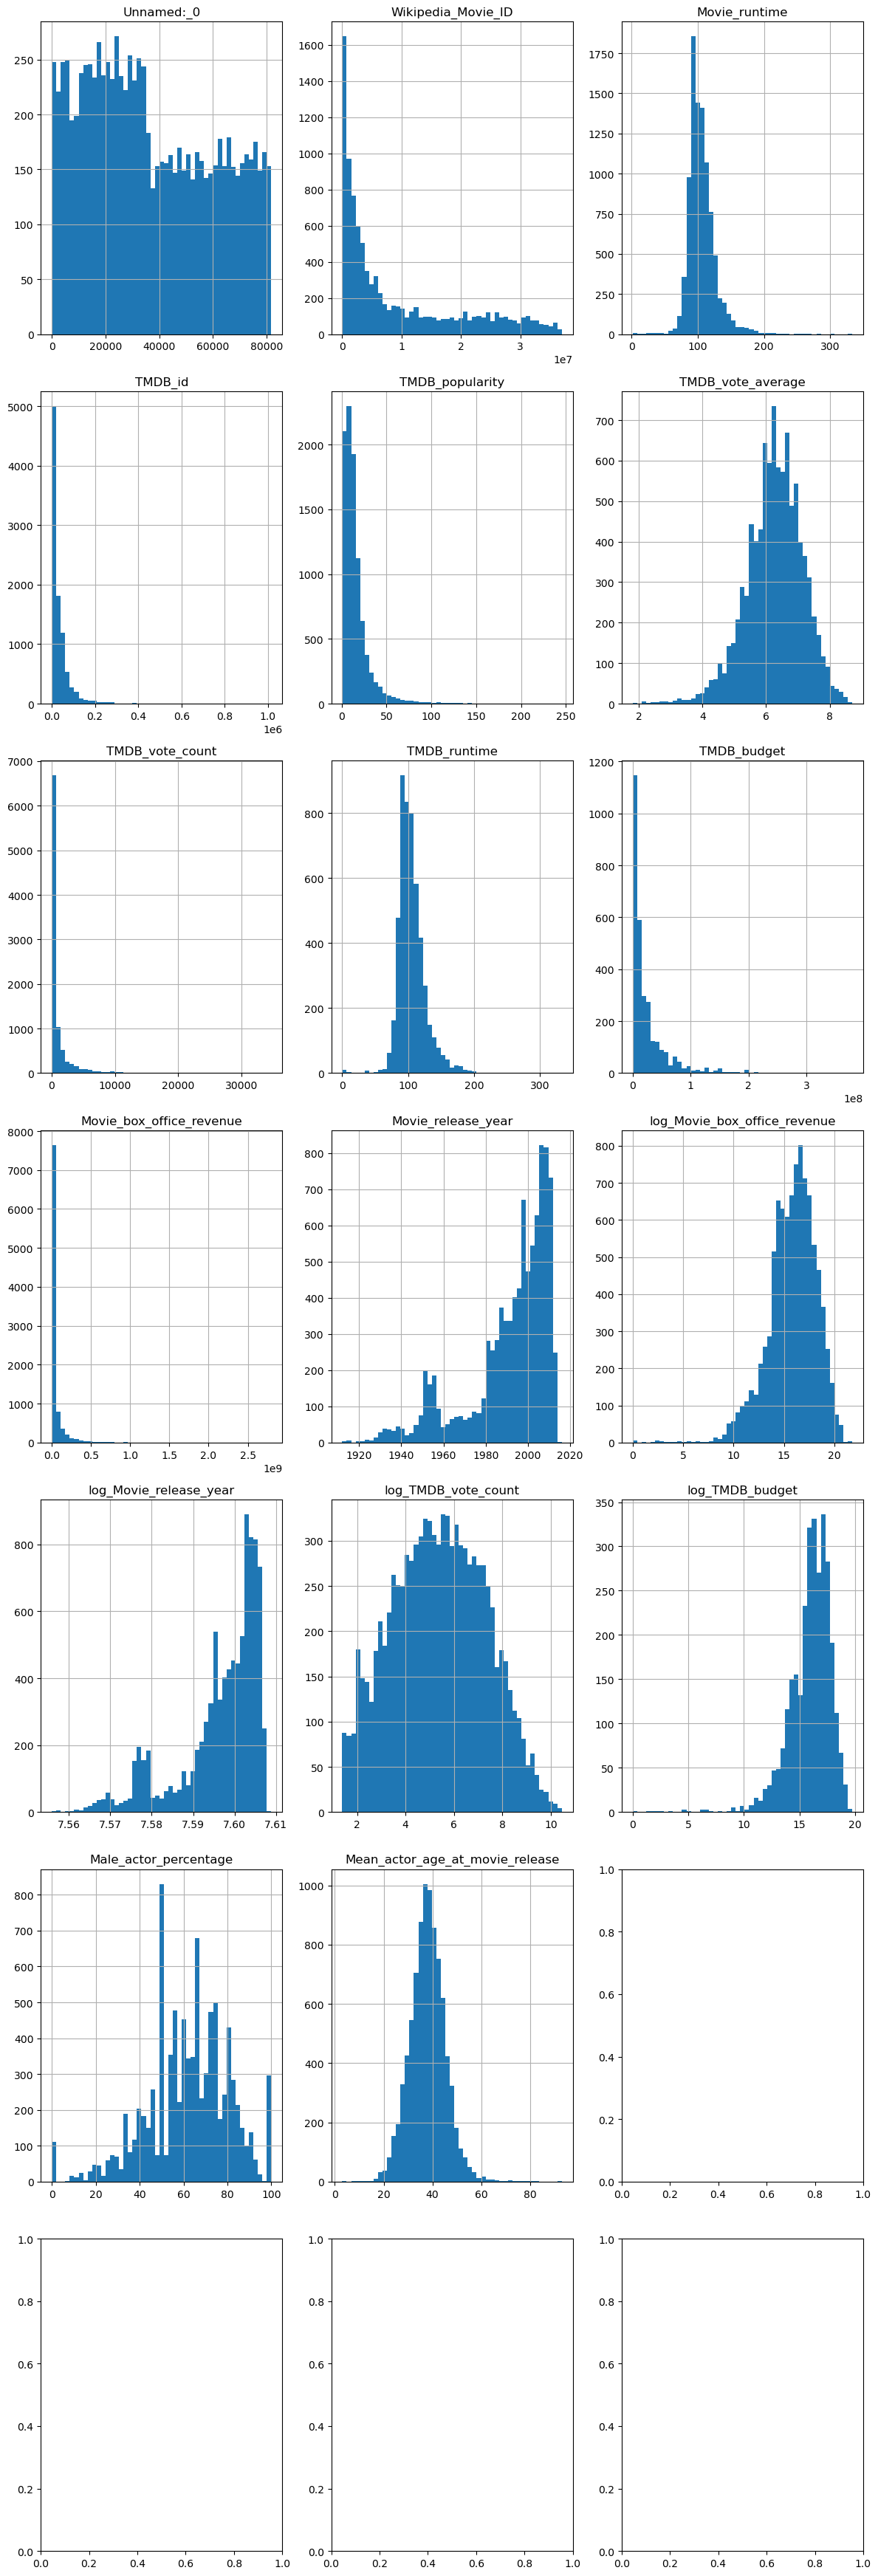

In [38]:
# Calculate the number of rows and columns dynamically
num_cols = 3
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols + 1  # Corrected this line

# Increase figure size and adjust layout
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 5 * num_rows))

# Plot histograms for each numeric column
for i, col in enumerate(numeric_columns):
    row, col_index = divmod(i, num_cols)
    
    # Adjust binning based on the data range
    bins = np.linspace(movie_metadata[col].min(), movie_metadata[col].max(), 50)
    
    movie_metadata[col].hist(ax=axes[row, col_index], bins=bins)
    axes[row, col_index].set_title(col)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


**Save cleaned dataframe**


In [36]:
movie_metadata.to_csv('data_cleaned/movie_cleaned_02.csv')
character_metadata.to_csv('data_cleaned/character_cleaned_02.csv')